In [23]:
import os
import shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#import keras and different type of layers for for defining CNN models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.metrics import Precision, Recall

In [2]:
rawDataDir = '448/'

In [5]:
crack_images = os.listdir(rawDataDir+'Cracks')
print(len(crack_images))

200


In [6]:
uncrack_images = os.listdir(rawDataDir+'NonCracks')
print(len(uncrack_images))

200


## Visualize Images with crack

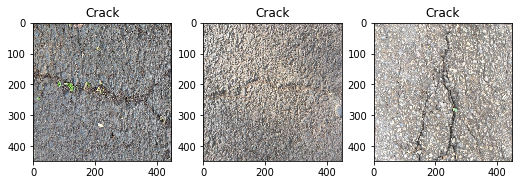

In [15]:
random_crack_images_indices = np.random.randint(0, len(crack_images), 3)
random_crack_images = [os.path.join(rawDataDir+'Cracks/'+crack_images[index]) for index in random_crack_images_indices]
fig = plt.figure(figsize=(30, 30))
for j in range(3):
    axisarr = fig.add_subplot(10, 10, j+1)
    axisarr.imshow(mpimg.imread(os.path.join(random_crack_images[j])))
    axisarr.set_title('Crack')
plt.show()

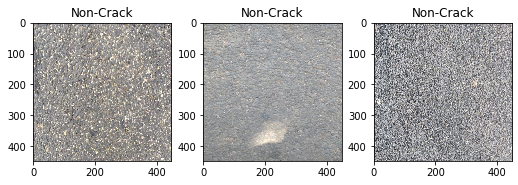

In [16]:
random_uncrack_images_indices = np.random.randint(0, len(uncrack_images), 3)
random_uncrack_images = [os.path.join(rawDataDir+'NonCracks/'+uncrack_images[index]) for index in random_uncrack_images_indices]
fig = plt.figure(figsize=(30, 30))
for j in range(3):
    axisarr = fig.add_subplot(10, 10, j+1)
    axisarr.imshow(mpimg.imread(os.path.join(random_uncrack_images[j])))
    axisarr.set_title('Non-Crack')
plt.show()

#### Make directory structure which is required for ImageDataGeneratorClass

In [18]:
os.mkdir('data/')
os.mkdir('data/train')
os.mkdir('data/test')
os.mkdir('data/visualization')

os.mkdir('data/train/crack')
os.mkdir('data/train/uncrack')
os.mkdir('data/test/crack')
os.mkdir('data/test/uncrack')
os.mkdir('data/visualization/real_images')

In [19]:
import random
random.shuffle(crack_images)
random.shuffle(uncrack_images)

In [20]:
train_crack_images = crack_images[0:150]
test_crack_images = crack_images[150:195]
visualization_crack_images = crack_images[195:200]

train_uncrack_images = uncrack_images[0:150]
test_uncrack_images = uncrack_images[150:195]
visualization_uncrack_images = uncrack_images[195:200]

In [21]:
baseDir = 'data/'
for image in train_crack_images:
    src = os.path.join(rawDataDir, 'Cracks/', image)
    dest = os.path.join(baseDir, 'train/crack')
    shutil.copy(src, dest)

for image in test_crack_images:
    src = os.path.join(rawDataDir, 'Cracks/', image)
    dest = os.path.join(baseDir, 'test/crack')
    shutil.copy(src, dest)

for image in visualization_crack_images:
    src = os.path.join(rawDataDir, 'Cracks/', image)
    dest = os.path.join(baseDir, 'visualization/real_images')
    shutil.copy(src, dest)

for image in train_uncrack_images:
    src = os.path.join(rawDataDir, 'NonCracks/', image)
    dest = os.path.join(baseDir, 'train/uncrack')
    shutil.copy(src, dest)

for image in test_uncrack_images:
    src = os.path.join(rawDataDir, 'NonCracks/', image)
    dest = os.path.join(baseDir, 'test/uncrack')
    shutil.copy(src, dest)

for image in visualization_uncrack_images:
    src = os.path.join(rawDataDir, 'NonCracks/', image)
    dest = os.path.join(baseDir, 'visualization/real_images')
    shutil.copy(src, dest)    

# LeNet-5 Model

In [24]:
lenetModel = Sequential()
lenetModel.add(Conv2D(6, (5, 5), strides=(1, 1), padding='valid', input_shape=(448, 448, 3)))
lenetModel.add(Activation('relu'))
lenetModel.add(AveragePooling2D(pool_size=(2, 2), strides=(2,2)))

lenetModel.add(Conv2D(16, (5, 5), padding='valid'))
lenetModel.add(Activation('relu'))
lenetModel.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

lenetModel.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
lenetModel.add(Dense(120))
lenetModel.add(Activation('relu'))
lenetModel.add(Dense(units=84))
lenetModel.add(Activation('relu'))
lenetModel.add(Dense(1)) # this our output layer (since this is binary classification of cracked or uncracked, we use only one unit in output layer).
lenetModel.add(Activation('sigmoid'))

lenetModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
lenetModel.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 444, 444, 6)       456       
_________________________________________________________________
activation_1 (Activation)    (None, 444, 444, 6)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 222, 222, 6)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 218, 218, 16)      2416      
_________________________________________________________________
activation_2 (Activation)    (None, 218, 218, 16)      0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 109, 109, 16)      0         
_________________________

In [25]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 32

# this is the augmentation configuration we will use for training
#here along with rescaling, we are also changing the orientation of the image in only training dataset, 
#this is we are doing so that our model never sees the same image, and this will help in fighting overfitting.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing, validation, visualization:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)
visualization_datagen = ImageDataGenerator(rescale=1./255)


# this is a generator that will read pictures found in
# subfolers of 'master_data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(448, 448),  # all images will be resized to 227*227
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for test data
test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(448, 448),
        batch_size=batch_size,
        class_mode='binary')

# this is a similar generator, for visualization data
visualization_generator = visualization_datagen.flow_from_directory(
        'data/visualization',
        target_size=(448, 448),
        batch_size=batch_size,
        class_mode='binary')

Found 300 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Found 10 images belonging to 1 classes.


In [26]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.01)

In [27]:
import time
start_time = time.time() 
lenetModel.fit_generator(
        train_generator,
        epochs=10,
        validation_data=test_generator,
        callbacks=[es]
)
finish_time = time.time()
time_taken = finish_time-start_time
print('\n')
print('Training complete in {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))


Epoch 1/10
10/10 [==============================] - 12s 1s/step - loss: 4.1273 - accuracy: 0.4667 - precision_1: 0.4638 - recall_1: 0.4267 - val_loss: 0.6696 - val_accuracy: 0.4889 - val_precision_1: 0.4930 - val_recall_1: 0.7778
Epoch 2/10
10/10 [==============================] - 10s 970ms/step - loss: 0.6744 - accuracy: 0.5733 - precision_1: 0.5632 - recall_1: 0.6533 - val_loss: 0.6118 - val_accuracy: 0.6667 - val_precision_1: 0.6923 - val_recall_1: 0.6000
Epoch 3/10
10/10 [==============================] - 10s 1s/step - loss: 0.6474 - accuracy: 0.6667 - precision_1: 0.6667 - recall_1: 0.6667 - val_loss: 0.7783 - val_accuracy: 0.5333 - val_precision_1: 0.5172 - val_recall_1: 1.0000
Epoch 4/10
10/10 [==============================] - 10s 1s/step - loss: 0.6565 - accuracy: 0.5767 - precision_1: 0.5535 - recall_1: 0.7933 - val_loss: 0.6952 - val_accuracy: 0.5000 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 10s 1s/step - lo

In [28]:
test_loss, accuracy, precision, recall = lenetModel.evaluate_generator(test_generator)

In [29]:
print(' accuracy : ', accuracy, '\n', 'precision : ', precision, '\n', 'recall : ', recall)

 accuracy :  0.6333333253860474 
 precision :  0.6363636255264282 
 recall :  0.6222222447395325


In [30]:
imgarr = visualization_generator[0][0]
imgarr.shape

(10, 448, 448, 3)

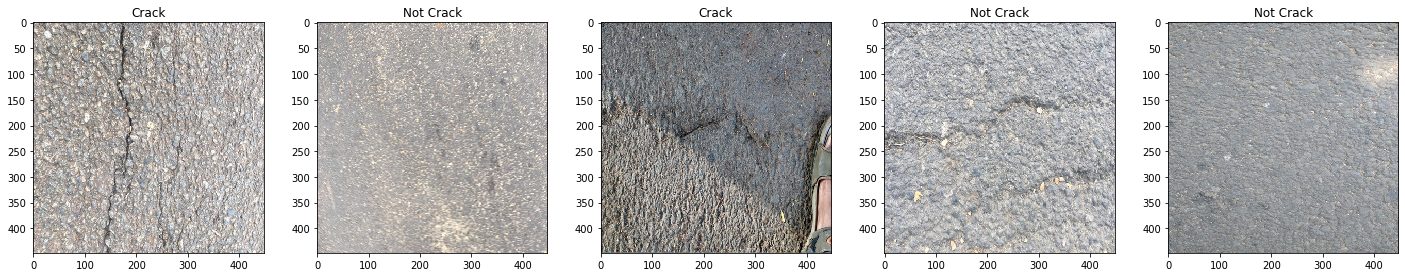

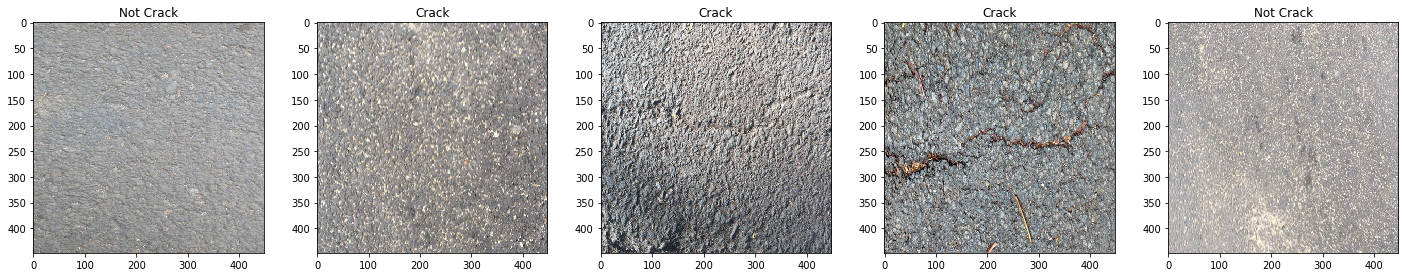

In [31]:
import numpy as np

predictions = lenetModel.predict(imgarr)
pred_class_arr = np.array(predictions).round()
counter = 0
for i in range(2):
    fig = plt.figure(figsize=(50, 50))
    for j in range(5):
        axisarr = fig.add_subplot(10, 10, j+1)
        axisarr.imshow(imgarr[counter])
        if(pred_class_arr[counter] == 0):
            axisarr.set_title('Crack')
        else:
            axisarr.set_title('Not Crack')
        counter += 1

In [32]:
#save the model
lenetModel.save(
    'lenet_model.h5',
    overwrite=True,
    include_optimizer=True,
)

In [33]:
lenetModel.save_weights('lenetModelWeights.h5')

In [34]:
from keras.models import load_model

In [36]:
lenetModel_pt = Sequential()
lenetModel_pt.add(Conv2D(6, (5, 5), strides=(1, 1), padding='valid', input_shape=(227, 227, 3)))
lenetModel_pt.add(Activation('relu'))
lenetModel_pt.add(AveragePooling2D(pool_size=(2, 2), strides=(2,2)))

lenetModel_pt.add(Conv2D(16, (5, 5), padding='valid'))
lenetModel_pt.add(Activation('relu'))
lenetModel_pt.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

lenetModel_pt.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
lenetModel_pt.add(Dense(120))
lenetModel_pt.add(Activation('relu'))
lenetModel_pt.add(Dense(units=84))
lenetModel_pt.add(Activation('relu'))
lenetModel_pt.add(Dense(1)) # this our output layer (since this is binary classification of cracked or uncracked, we use only one unit in output layer).
lenetModel_pt.add(Activation('sigmoid'))

lenetModel_pt.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
lenetModel_pt.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 223, 223, 6)       456       
_________________________________________________________________
activation_6 (Activation)    (None, 223, 223, 6)       0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 111, 111, 6)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 107, 107, 16)      2416      
_________________________________________________________________
activation_7 (Activation)    (None, 107, 107, 16)      0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 53, 53, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 44944)            

In [37]:
lenetModel_pt.load_weights('lenetModelWeights_40K.h5')

In [40]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 32

# this is the augmentation configuration we will use for training
#here along with rescaling, we are also changing the orientation of the image in only training dataset, 
#this is we are doing so that our model never sees the same image, and this will help in fighting overfitting.
train_datagen_pt = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing, validation, visualization:
# only rescaling
test_datagen_pt = ImageDataGenerator(rescale=1./255)
visualization_datagen_pt = ImageDataGenerator(rescale=1./255)


# this is a generator that will read pictures found in
# subfolers of 'master_data/train', and indefinitely generate
# batches of augmented image data
train_generator_pt = train_datagen_pt.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(227, 227),  # all images will be resized to 227*227
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for test data
test_generator_pt = test_datagen_pt.flow_from_directory(
        'data/test',
        target_size=(227, 227),
        batch_size=batch_size,
        class_mode='binary')

# this is a similar generator, for visualization data
visualization_generator_pt = visualization_datagen_pt.flow_from_directory(
        'data/visualization',
        target_size=(227, 227),
        batch_size=batch_size,
        class_mode='binary')

Found 300 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Found 10 images belonging to 1 classes.


In [41]:
import time
start_time_pt = time.time() 
lenetModel_pt.fit_generator(
        train_generator_pt,
        epochs=10,
        validation_data=test_generator_pt,
        callbacks=[es]
)
finish_time_pt = time.time()
time_taken_pt = finish_time_pt - start_time_pt
print('\n')
print('Training complete in {:.0f}m {:.0f}s'.format(time_taken_pt // 60, time_taken_pt % 60))

Epoch 1/10
10/10 [==============================] - 4s 357ms/step - loss: 0.7003 - accuracy: 0.8033 - precision_2: 0.7571 - recall_2: 0.8933 - val_loss: 1.0315 - val_accuracy: 0.7778 - val_precision_2: 0.6923 - val_recall_2: 1.0000
Epoch 2/10
10/10 [==============================] - 3s 317ms/step - loss: 0.5517 - accuracy: 0.7900 - precision_2: 0.7351 - recall_2: 0.9067 - val_loss: 0.4512 - val_accuracy: 0.7556 - val_precision_2: 0.7674 - val_recall_2: 0.7333
Epoch 3/10
10/10 [==============================] - 3s 322ms/step - loss: 0.3435 - accuracy: 0.8433 - precision_2: 0.8456 - recall_2: 0.8400 - val_loss: 0.3812 - val_accuracy: 0.7667 - val_precision_2: 0.7857 - val_recall_2: 0.7333
Epoch 4/10
10/10 [==============================] - 3s 332ms/step - loss: 0.3168 - accuracy: 0.8500 - precision_2: 0.8832 - recall_2: 0.8067 - val_loss: 0.2965 - val_accuracy: 0.7889 - val_precision_2: 0.7955 - val_recall_2: 0.7778
Epoch 5/10
10/10 [==============================] - 3s 332ms/step - loss

In [42]:
test_loss_pt, accuracy_pt, precision_pt, recall_pt = lenetModel_pt.evaluate_generator(test_generator_pt)

In [43]:
print(' accuracy_pt : ', accuracy_pt, '\n', 'precision_pt : ', precision_pt, '\n', 'recall_pt : ', recall_pt)

 accuracy_pt :  0.8222222328186035 
 precision_pt :  0.8222222328186035 
 recall_pt :  0.8222222328186035


In [44]:
imgarr_pt = visualization_generator_pt[0][0]
imgarr_pt.shape

(10, 227, 227, 3)

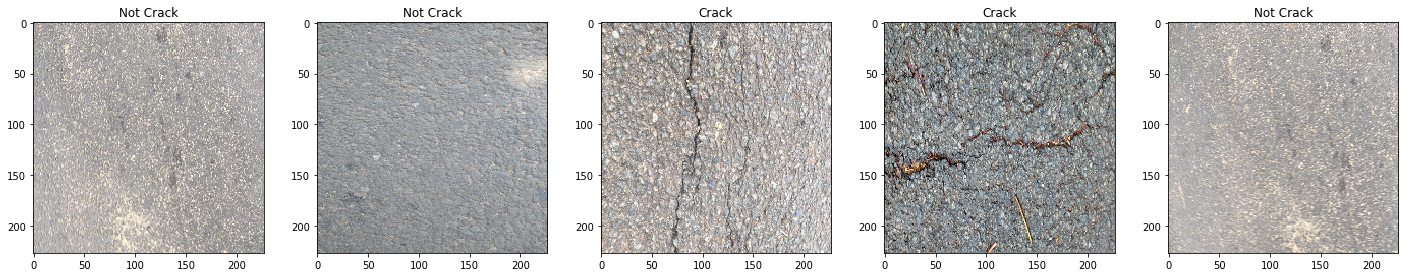

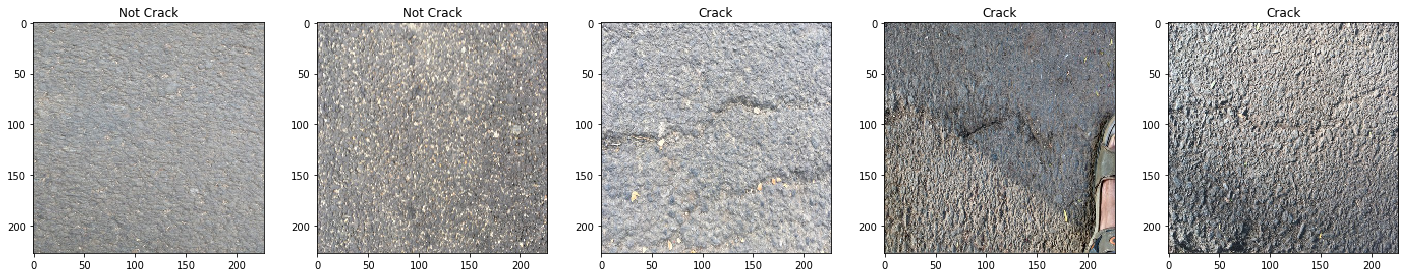

In [45]:
import numpy as np

predictions_pt = lenetModel_pt.predict(imgarr_pt)
pred_class_arr_pt = np.array(predictions_pt).round()
counter = 0
for i in range(2):
    fig = plt.figure(figsize=(50, 50))
    for j in range(5):
        axisarr = fig.add_subplot(10, 10, j+1)
        axisarr.imshow(imgarr_pt[counter])
        if(pred_class_arr_pt[counter] == 0):
            axisarr.set_title('Crack')
        else:
            axisarr.set_title('Not Crack')
        counter += 1

In [46]:
#save the model
lenetModel_pt.save(
    'lenet_model_pt.h5',
    overwrite=True,
    include_optimizer=True,
)

In [47]:
lenetModel_pt.save_weights('lenetModelWeights_pt.h5')